# Ovarian cancer data analysis
Train steamboat model on HGSC data.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scanpy squidpy

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of ome-zarr to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.3/161.3 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/

In [3]:
import os
import scanpy as sc
import squidpy as sq
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

/usr/lib/python3.12/importlib/__init__.py:90: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)
/usr/local/lib/python3.12/dist-packages/anndata/__init__.py:44: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)


In [4]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['font.family'] = 'DejaVu Sans'

pltkw = dict(bbox_inches='tight', transparent=True)

In [5]:
##Working with google colab
os.chdir("/content/drive/MyDrive/Thesis/Projects/Steamboat_X/examples")
cwd = os.getcwd()
print(cwd)

/content/drive/MyDrive/Thesis/Projects/Steamboat_X/examples


In [6]:
import os
import sys
sys.path.append("..")
import steamboat as sf
import steamboat.tools
import torch
if torch.cuda.is_available():
    device = "cuda"
    print(torch.cuda.get_device_name(0))
else:
    device = "cpu"
    print("Using CPU")

NVIDIA A100-SXM4-40GB


In [37]:
import importlib
importlib.reload(steamboat.tools)

<module 'steamboat.tools' from '/content/drive/MyDrive/Thesis/Projects/Steamboat_X/examples/../steamboat/tools.py'>

In [ ]:
# https://www.nature.com/articles/s41590-024-01943-5

## Load data

In [7]:
h5ad_file = "../../Data/Steamboat_Data/1/Ex1_hgsc/ST_Discovery_so.h5ad"
os.path.exists(h5ad_file)

True

In [ ]:
os.path.exists("../../Data/Steamboat_Data/2/Ex1_hgsc/sample_metadata.xlsx")

True

In [7]:
regenerate = False

h5ad_file = "../../Data/Steamboat_Data/1/Ex1_hgsc/ST_Discovery_so.h5ad"
if (not os.path.exists(h5ad_file)) or regenerate:
    print("choose the right path")
    """
    adata = sc.read_mtx("G:/data/HGSC/Csv/ST_Discovery_so_counts.mtx").T
    metadata = pd.read_csv("G:/data/HGSC/Csv/ST_Discovery_so_metadata.csv", index_col=0)
    features = pd.read_csv("G:/data/HGSC/Csv/ST_Discovery_so_features.txt", index_col=0, header=None)
    features.index = features.index.str.strip() # remove trailing white space in gene names
    features.index.name = 'gene_symbol'
    adata.obs = metadata
    adata.var = features
    adata.obsm['spatial'] = adata.obs[['x', 'y']].to_numpy()
    adata.write_h5ad("G:/data/HGSC/h5ad/ST_Discovery_so.h5ad")
    """
else:
    adata = sc.read_h5ad(h5ad_file)

In [ ]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,samples,patients,sites_binary,cell.types,cell.subtypes,x,y
SMI_T10_F001_c1017,SMI,848,357,SMI_T10_F001,HGSC1,Adnexa,Malignant,Malignant,1493.3500,3151.233
SMI_T10_F001_c102,SMI,731,319,SMI_T10_F001,HGSC1,Adnexa,Malignant,Malignant,2623.2000,3607.450
SMI_T10_F001_c1062,SMI,236,155,SMI_T10_F001,HGSC1,Adnexa,Malignant,Malignant,850.5670,3143.833
SMI_T10_F001_c1064,SMI,609,300,SMI_T10_F001,HGSC1,Adnexa,Malignant,Malignant,3222.7300,3152.586
SMI_T10_F001_c1075,SMI,310,174,SMI_T10_F001,HGSC1,Adnexa,Malignant,Malignant,78.0125,3179.012
...,...,...,...,...,...,...,...,...,...,...
SMI_T14_F020_c5758,SMI,100,63,SMI_T14_F020,HGSC89,Omentum,TNK.cell,CD4.T.cell.DN,5170.4400,431.900
SMI_T14_F020_c734,SMI,141,88,SMI_T14_F020,HGSC89,Omentum,Fibroblast,Fibroblast,768.7000,3188.400
SMI_T14_F020_c875,SMI,78,60,SMI_T14_F020,HGSC89,Omentum,Malignant,Malignant,42.5833,3070.350
SMI_T14_F020_c3288,SMI,104,58,SMI_T14_F020,HGSC89,Omentum,Fibroblast,Fibroblast,48.9889,1751.740


In [8]:
## Metadata and gene sets

sample_metadata = pd.read_excel("../../Data/Steamboat_Data/2/Ex1_hgsc/sample_metadata.xlsx", index_col=0, sheet_name='Table 2b', skiprows=1)

#We have different datasets and splited them through discovery/validation/test
sample_metadata = sample_metadata[sample_metadata['dataset'] == 'Discovery']

#The signature genes for each cell type
#celltype_signatures = pd.read_excel("G:/data/HGSC/sample_metadata.xlsx", sheet_name='Table 3a', skiprows=2)
celltype_signatures = pd.read_excel("../../Data/Steamboat_Data/2/Ex1_hgsc/sample_metadata.xlsx", index_col=0, sheet_name='Table 3b', skiprows=2).iloc[:, :-3]

#M_TIL program genes
mtil_signautures = pd.read_excel("../../Data/Steamboat_Data/2/Ex1_hgsc/sample_metadata.xlsx", sheet_name='Table 6a', skiprows=2)

#Genes most strongly linked to the desmoplastic reaction
desmoplasia_signautures = pd.read_excel("../../Data/Steamboat_Data/2/Ex1_hgsc/sample_metadata.xlsx", sheet_name='Table 5a', skiprows=2)


def purge_gene_sets(df, prefix=''):
    res = {}
    for i in df.columns:
        res[prefix + i] = df[i].dropna().tolist()
    return res

genesets = (purge_gene_sets(celltype_signatures, 'sig_') |
            purge_gene_sets(mtil_signautures, 'mtil_'))


del genesets['sig_Mast.cell']

genesets.keys()


dict_keys(['sig_B.cell', 'sig_Monocyte', 'sig_TNK.cell', 'sig_Fibroblast', 'sig_Malignant', 'mtil_UP', 'mtil_DOWN'])

In [26]:
genesets.items()

dict_items([('sig_B.cell', ['CD27', 'CD38', 'CD79A', 'DUSP5', 'FKBP11', 'IGHA1', 'IGHG1', 'IGHG2', 'IGHM', 'IGKC', 'IRF4', 'JCHAIN', 'LPAR5', 'MZB1', 'ST6GAL1', 'XBP1']), ('sig_Monocyte', ['AXL', 'C1QA', 'C1QB', 'C1QC', 'CCL2', 'CCR1', 'CD14', 'CD163', 'CD300A', 'CD4', 'CD68', 'CD74', 'CFD', 'CIITA', 'CLEC7A', 'CMKLR1', 'CSF1R', 'CSF2RA', 'CSF3R', 'CXCL16', 'CXCL9', 'FCER1G', 'FCGBP', 'FCGR3A', 'FGR', 'FPR1', 'GLUL', 'GPNMB', 'GPR183', 'GPX1', 'HAVCR2', 'HCK', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DRA', 'HLA-DRB1', 'HLA-DRB5', 'IFNGR1', 'IL10RA', 'IL18', 'ITGAM', 'ITGAX', 'ITGB2', 'LAIR1', 'LGALS9', 'LYN', 'LYZ', 'MERTK', 'MMP9', 'MS4A4A', 'OLR1', 'PSAP', 'SAT1', 'SERPINA1', 'SPP1', 'TLR1', 'TLR2', 'TLR4', 'TYROBP', 'VSIR']), ('sig_TNK.cell', ['ADGRE5', 'ARHGDIB', 'BCL2', 'BTG1', 'CASP8', 'CCL4', 'CCL4L2', 'CCL5', 'CCR5', 'CD2', 'CD3D', 'CD3E', 'CD3G', 'CD48', 'CD52', 'CD8A', 'CLEC2D', 'CST7', 'CTLA4', 'CTSW', 'CXCR3', 'CXCR4', 'CXCR6', 'DUSP2', 'DUSP4', 'FYB1', 'FYN', '

In [ ]:
sample_metadata

,dataset,platform,n_cells,median_tpc,mean_tpc,TMA,patients,sites_binary,age,stage,...,fu_time2,outcome,pfs,BRCA1_Somatic,BRCA2_Somatic,TP53_Somatic,BRCA1_Germline,BRCA2_Germline,TP53_Germline,tmb
profile,,,,,,,,,,,,,,,,,,,,,
SMI_T10_F001,Discovery,SMI,5660,205.0,238.675618,TMA 10,HGSC1,Adnexa,58.0,III,...,775.0,Alive,775.0,WT,P,P,US,US,US,6.80
SMI_T10_F002,Discovery,SMI,8821,364.0,393.318671,TMA 10,HGSC7,Adnexa,58.0,III,...,1013.0,Alive,1013.0,P,WT,LP,US,US,US,0.53
SMI_T10_F003,Discovery,SMI,2881,300.0,445.154460,TMA 10,HGSC8,Adnexa,65.0,IV,...,781.0,Alive,200.0,WT,WT,P,US,US,US,3.16
SMI_T10_F004,Discovery,SMI,3145,286.0,376.895390,TMA 10,HGSC13,Omentum,67.0,III,...,840.0,Dead (disease),161.0,WT,WT,P,US,US,US,2.63
SMI_T10_F005,Discovery,SMI,2187,165.0,267.202561,TMA 10,HGSC15,Adnexa,33.0,IV,...,845.0,Alive,845.0,WT,WT,P,P,US,US,2.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SMI_T14_F016,Discovery,SMI,2744,209.0,288.211735,TMA 14,HGSC61,Omentum,70.0,III,...,1955.0,Alive,1955.0,WT,WT,P,US,US,US,1.10
SMI_T14_F017,Discovery,SMI,3376,276.0,368.816647,TMA 14,HGSC63,Omentum,71.0,III,...,407.0,D/c to hospice (likely dead of disease),297.0,WT,WT,P,US,US,US,0.50
SMI_T14_F018,Discovery,SMI,9961,189.0,210.500452,TMA 14,HGSC89,Adnexa,53.0,III,...,1729.0,Dead (disease),412.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


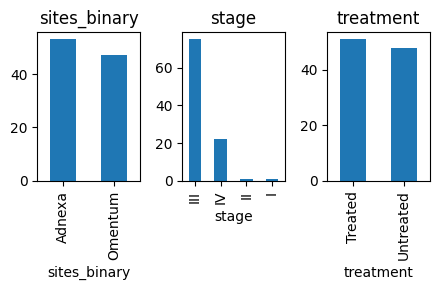

In [9]:
## Find untreated, adnexa samples

columns_of_interest = ['sites_binary', 'stage', 'treatment']
fig, axes = plt.subplots(1, len(columns_of_interest), figsize=(len(columns_of_interest) * 1.5, 3))
for i, column in enumerate(columns_of_interest):
    sample_metadata[column].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(column)
plt.tight_layout()


#Only keep samples from Adnexa region and untreated
mask = (sample_metadata['sites_binary'] == 'Adnexa') & (sample_metadata['treatment'] == 'Untreated')
samples_of_interest = sample_metadata.index[mask].tolist()

all_adata = adata[adata.obs['samples'].isin(samples_of_interest)].copy()
all_adata.obs['cell.types.nolc'] = all_adata.obs['cell.types'].str.replace('_LC', '')

In [ ]:
### Have a look at the spatial distribution of cells

## Train a Steamboat model

### Process data to create torch dataset

In [10]:
## See the inside

data_matrix = all_adata[all_adata.obs['samples'] == 'SMI_T10_F001'].X.toarray()

# Create DataFrame
df = pd.DataFrame(
    data_matrix,
    index=all_adata[all_adata.obs['samples'] == 'SMI_T10_F001'].obs_names,   # cell IDs
    columns=all_adata[all_adata.obs['samples'] == 'SMI_T10_F001'].var_names  # gene names
)

# Reset index to make cell IDs a column
df.reset_index(inplace=True)
df.rename(columns={'index': 'cell_id'}, inplace=True)

df.head()

gene_symbol,cell_id,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,ACTA2,...,WNT5B,WNT7A,WNT7B,WNT9A,XBP1,XCL1,XCL2,YBX3,YES1,ZFP36
0,SMI_T10_F001_c1017,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,2.0,0.0,4.0,2.0,5.0,0.0,0.0,0.0,1.0,0.0
1,SMI_T10_F001_c102,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,2.0,0.0,12.0,0.0,0.0,0.0,2.0,0.0
2,SMI_T10_F001_c1062,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,SMI_T10_F001_c1064,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
4,SMI_T10_F001_c1075,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Separate individual slides
adatas = []
for i in all_adata.obs['samples'].unique():
    temp = all_adata[all_adata.obs['samples'] == i].copy()
    if temp.shape[0] < 100:
        continue
    adatas.append(temp)
    adatas[-1].obs['global'] = 0

# normalize and log transformation
adatas = sf.prep_adatas(adatas, norm=True, log1p=True, scale=False, renorm=False)

# create torch dataset
dataset = sf.make_dataset(adatas, sparse_graph=True, regional_obs=['global'])

  0%|          | 0/27 [00:00<?, ?it/s]

Using ['global'] as regional annotations.


  0%|          | 0/27 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


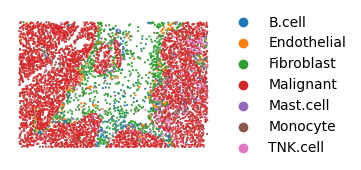

In [12]:
sq.pl.spatial_scatter(adatas[0], color=['cell.types.nolc'], shape=None, figsize=(3.5, 3.5), size=.5,
                      legend_fontsize=10, cmap='Reds', ncols=3, colorbar=False, vmin=0., wspace=.0, outline=False, frameon=False, title="")

In [15]:
# Move data into vmem

if device == 'cuda':
    cuda_dataset = dataset.to('cuda')

### Create model and train

In [13]:
n_heads = 25

sf.set_random_seed(0)
model = sf.Steamboat(adata.var_names.tolist(), n_heads=n_heads, n_scales=3)
model = model.to(device)

In [ ]:
use_dataset = cuda_dataset
if use_dataset is None:
    use_dataset = dataset

model.fit(cuda_dataset, entry_masking_rate=0.1, feature_masking_rate=0.1,
          max_epoch=10000,
          loss_fun=torch.nn.MSELoss(reduction='sum'),
          opt=torch.optim.Adam, opt_args=dict(lr=0.1), stop_eps=1e-3, report_per=200, stop_tol=200, device=device)

### Save/load model

In [ ]:
torch.save(model.state_dict(), 'saved_models/hgsc_new.pth')

In [14]:
model.load_state_dict(torch.load('saved_models/hgsc_new.pth'))

<All keys matched successfully>

### Calculate attention scores and save AnnData

In [15]:
sf.tools.calc_obs(adatas, dataset, model, get_recon=True)
sf.tools.gather_obs(all_adata, adatas)

100%|██████████| 27/27 [00:03<00:00,  8.86it/s]


AnnData object with n_obs × n_vars = 161962 × 979
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'samples', 'patients', 'sites_binary', 'cell.types', 'cell.subtypes', 'x', 'y', 'cell.types.nolc'
    obsm: 'spatial', 'q', 'local_k', 'ego_attn', 'local_attn', 'global_attn', 'attn', 'global_k_0', 'X_recon'

In [ ]:
all_adata.write_h5ad("../../Data/Steamboat_Data/saved_h5ad/hgsc.h5ad")

In [22]:
all_adata = sc.read_h5ad("../../Data/Steamboat_Data/saved_h5ad/hgsc.h5ad")

In [16]:
all_adata.obsm

AxisArrays with keys: spatial, q, local_k, ego_attn, local_attn, global_attn, attn, global_k_0, X_recon

In [24]:
# Embedding for cell-cell interaction?
# Could there be two pairs of cell types with similar interaction?
# E.g.???

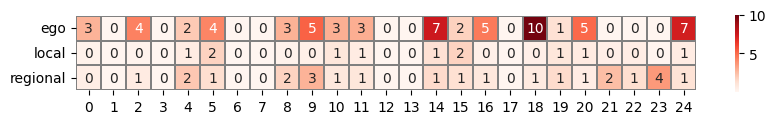

In [16]:
head_weights = sf.tools.calc_head_weights(device, adatas, model)
sf.tools.plot_head_weights(head_weights)

## Metagene interpretation: cell types and states

Stupid_2


(<Figure size 1000x600 with 6 Axes>,
 <Axes: xlabel='Global environment metagenes'>)

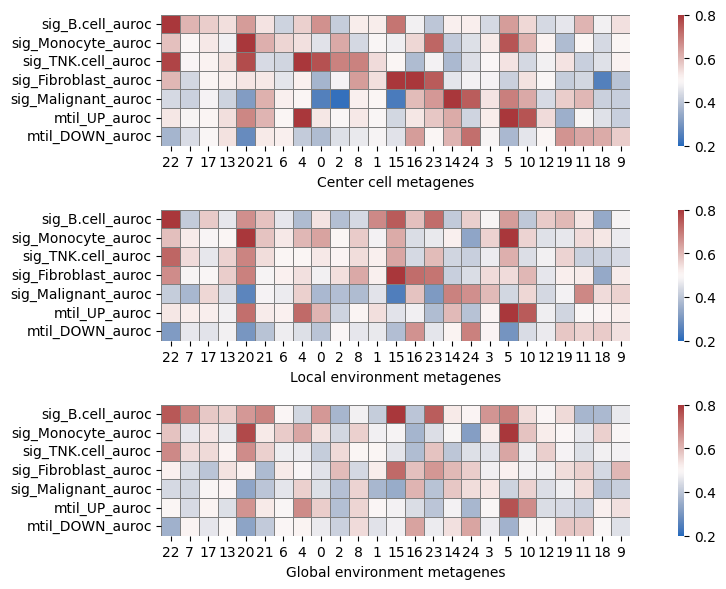

In [17]:
#Write metagenes into a DataFrame
gene_df = sf.tools.calc_var(model)

#gene set enrichment analysis (GSEA) but using AUROC instead of the usual ranking-based statistics
sig_df = sf.tools.calc_geneset_auroc(gene_df, genesets)

#Just ordering for visualization
metagene_order = sf.tools.calc_geneset_auroc_order(sig_df)
sf.tools.plot_geneset_auroc(sig_df, metagene_order)

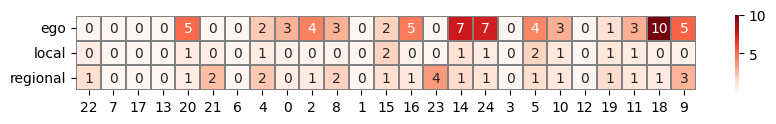

In [18]:
#To see the role of each head in obtaining the inf. from each category (ego/local/regional)
sf.tools.plot_head_weights(head_weights, 100, metagene_order)

/tmp/ipython-input-1474094706.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  plt_df = pd.pivot_table(plt_df, index=["samples"], columns=["cell.types.nolc"], values=[f"q_{i_head}"], aggfunc=np.median)
/tmp/ipython-input-1474094706.py:5: FutureWarning: The provided callable <function median at 0x7fc098f74cc0> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  plt_df = pd.pivot_table(plt_df, index=["samples"], columns=["cell.types.nolc"], values=[f"q_{i_head}"], aggfunc=np.median)
/tmp/ipython-input-1474094706.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and re

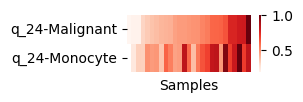

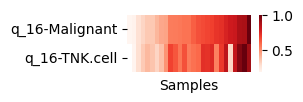

In [19]:
def plot_helper(all_adata, i_head, celltypes):
    plt_df = all_adata.obs.copy()
    plt_df[f'q_{i_head}'] = all_adata.obsm['q'][:, i_head]
    plt_df = plt_df[plt_df['cell.types.nolc'].isin(celltypes)]
    plt_df = pd.pivot_table(plt_df, index=["samples"], columns=["cell.types.nolc"], values=[f"q_{i_head}"], aggfunc=np.median)
    plt_df = plt_df.sort_values(by=(f"q_{i_head}", celltypes[0]))

    fig, ax = plt.subplots(figsize=(2, 0.75))
    sns.heatmap((plt_df / plt_df.max()).T, ax=ax, cmap='Reds')
    ax.set_xticks([])
    ax.set_ylabel('')
    ax.set_xlabel('Samples')

plot_helper(all_adata, 24, ['Malignant', 'Monocyte'])
plot_helper(all_adata, 16, ['Malignant', 'TNK.cell'])

In [ ]:
# investigate the overlap between Mtil and Monocyte (Up)
# This part is completely from the original publication.
# It has nothing to do with Steamboat
immune_til = pd.read_excel("../../Data/Steamboat_Data/2/Ex1_hgsc/sample_metadata.xlsx", index_col=None, sheet_name='Table 4a', skiprows=1)
immune_til = purge_gene_sets(immune_til)
immune_genes = set()
for k, v in immune_til.items():
    if 'Up' in k:
        immune_genes |= set(v)

# Define the parameters of the test
M = all_adata.shape[1]  # Total population size
n = len(set(genesets['mtil_UP']))  # Number of successes in the population
N = len(immune_til['Monocyte (Up)'])   # Sample size
k = len(set(genesets['mtil_UP']) & set(immune_til['Monocyte (Up)']))   # Number of successes in the sample

# Calculate the p-value
p_value = sp.stats.hypergeom.sf(k-1, M, n, N)

print("P-value:", p_value)

P-value: 2.824042372846463e-06


## Attention map interpretation: Cell-cell interaction

In [103]:
import importlib
importlib.reload(steamboat.tools)

<module 'steamboat.tools' from '/content/drive/MyDrive/Thesis/Projects/Steamboat_X/examples/../steamboat/tools.py'>

In [20]:
steamboat_cci = sf.tools.calc_interaction(device, adatas, model, 'samples', 'cell.types.nolc')
adjacency_cci = sf.tools.calc_adjacency_freq(device, adatas, 'samples', 'cell.types.nolc')

In [25]:
adatas[0].obsp.keys()

KeysView(PairwiseArrays with keys: spatial_connectivities, spatial_distances, local_attn_0, local_attn_1, local_attn_2, local_attn_3, local_attn_4, local_attn_5, local_attn_6, local_attn_7, local_attn_8, local_attn_9, local_attn_10, local_attn_11, local_attn_12, local_attn_13, local_attn_14, local_attn_15, local_attn_16, local_attn_17, local_attn_18, local_attn_19, local_attn_20, local_attn_21, local_attn_22, local_attn_23, local_attn_24)

In [21]:
def melt_helper(x):
  """

  This function reshapes a square interaction matrix
  (cell–cell interaction strengths) into a long format
  so that it can be compared across methods.

  """

  x_melt = x.melt(ignore_index=False)
  x_melt['variable'] = x_melt.index + '_' + x_melt['variable']
  return x_melt

cellchat_corr_dict = {}
cellchat_melt_dict = {}

cellchat_dict = {}

for k, v in steamboat_cci.items():
    cellchat_res_path = f"../../Data/Steamboat_Data/2/Ex1_hgsc/cellchat/{k}.csv"
    if os.path.isfile(cellchat_res_path):
        # print(cellchat_res_path)
        cellchat = pd.read_csv(cellchat_res_path, index_col=0)
        if (cellchat == 0).all().all():
            print(cellchat_res_path, 'all zero. Ignore.')
            continue

        cellchat_dict[k] = cellchat
        mine = v.copy()
        cellchat_melt = melt_helper(cellchat + cellchat.T)
        mine_melt = melt_helper(mine)

        adjacency_melt = melt_helper(adjacency_cci[k])
        adjacency_melt.columns = ['variable', 'value_adjacency']

        all_melt = pd.merge(cellchat_melt, mine_melt, on='variable', suffixes=['_cellchat', '_steamboat'])
        all_melt = pd.merge(all_melt, adjacency_melt, on='variable')

        corr_res = sp.stats.spearmanr(all_melt['value_cellchat'], all_melt['value_steamboat'])
        cellchat_melt_dict[k] = all_melt
        cellchat_corr_dict[k] = [corr_res.statistic, corr_res.pvalue]

        corr_res = sp.stats.spearmanr(all_melt['value_cellchat'], all_melt['value_adjacency'])
        cellchat_corr_dict[k].extend([corr_res.statistic, corr_res.pvalue])
    else:
        print(cellchat_res_path, 'not found!')

cellchat_corr_df = pd.DataFrame(cellchat_corr_dict, index=['steamboat_r', 'steamboat_p',
                                                           'adjacency_r', 'adjacency_p'])

cellchat_corr_df = cellchat_corr_df.T
cellchat_corr_df

../../Data/Steamboat_Data/2/Ex1_hgsc/cellchat/SMI_T11_F011.csv all zero. Ignore.


,steamboat_r,steamboat_p,adjacency_r,adjacency_p
SMI_T10_F001,0.592139,7.406483e-06,0.429699,2.061229e-03
SMI_T10_F002,0.676105,6.020565e-06,0.575617,2.397048e-04
SMI_T10_F006,0.912648,6.915974e-20,0.540967,5.991565e-05
SMI_T10_F014,0.849135,1.264228e-14,0.658272,2.739395e-07
SMI_T11_F001,0.706780,1.383677e-08,0.561502,2.698830e-05
SMI_T11_F002,0.727664,3.157551e-09,0.729006,2.858394e-09
SMI_T11_F004,0.672657,1.197439e-07,0.643418,6.153603e-07
SMI_T11_F008,0.260090,1.255300e-01,0.190274,2.663338e-01
SMI_T11_F009,0.770205,3.959761e-08,0.432830,8.372754e-03
SMI_T11_F020,0.826678,2.537215e-13,0.589490,8.326015e-06


np.float64(0.9230769230769231)

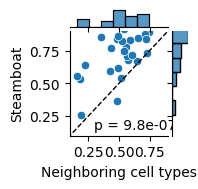

In [22]:
# fig, ax = plt.subplots(figsize=(2, 2))
# cellchat_corr_df.plot(kind='scatter', x='normneigh_r', y='steamboat_r', ax=ax)
g = sns.jointplot(
    data=cellchat_corr_df,
    x="adjacency_r", y="steamboat_r",
    kind="scatter",
    height=2,
    xlim=[0.1, .9],
    ylim=[0.1, .9]
)

ax = g.ax_joint

ax.set_xlabel('Neighboring cell types')
ax.set_ylabel('Steamboat')
ax.plot([.0, 1.], [.0, 1.], ls='--', lw=1., c='k')

test_res = sp.stats.wilcoxon(cellchat_corr_df['adjacency_r'], cellchat_corr_df['steamboat_r'])

ax.text(0.3, 0.15, f'p = {test_res.pvalue:.1e}')
(cellchat_corr_df['adjacency_r'] < cellchat_corr_df['steamboat_r']).sum() / cellchat_corr_df.shape[0]

# for pos in ['right', 'top']:
#    ax.spines[pos].set_visible(False)

# g.savefig("C:/Users/lshh/OneDrive/Publications/Steamboat/pub/fig-hgsc-elements/steamboat_vs_adjacency.pdf", **pltkw)

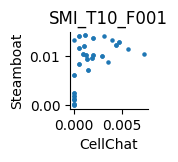

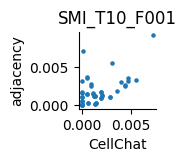

In [29]:
sample = 'SMI_T10_F001'
fig, ax = plt.subplots(figsize=(1., 1.))
cellchat_melt_dict[sample].plot(kind='scatter', x='value_cellchat', y='value_steamboat', ax=ax, title=sample, s=5.)

ax.set_xlabel('CellChat')
ax.set_ylabel('Steamboat')
for pos in ['right', 'top']:
        plt.gca().spines[pos].set_visible(False)
#fig.savefig(f"C:/Users/lshh/OneDrive/Publications/Steamboat/pub/fig-hgsc-elements/steamboat_{sample}.pdf", **pltkw)

fig, ax = plt.subplots(figsize=(1., 1.))
cellchat_melt_dict[sample].plot(kind='scatter', x='value_cellchat', y='value_adjacency', ax=ax, title=sample, s=5.)

ax.set_xlabel('CellChat')
ax.set_ylabel('adjacency')
for pos in ['right', 'top']:
        plt.gca().spines[pos].set_visible(False)
#fig.savefig(f"C:/Users/lshh/OneDrive/Publications/Steamboat/pub/fig-hgsc-elements/adjacency_{sample}.pdf", **pltkw)

## Misc visuals

### Visualize cell scores from head #0, #5, #15

In [39]:
len(adatas)

27

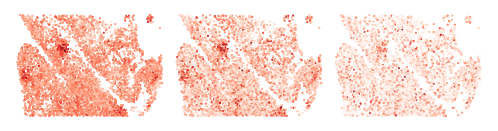

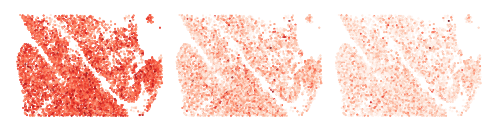

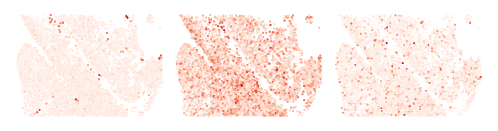

In [44]:
s = 20
for i_head in [4, 5, 15]:
    adatas[s].obs[f'q_{i_head}'] = adatas[s].obsm['q'][:, i_head]
    adatas[s].obs[f'local_k_{i_head}'] = adatas[s].obsm['local_k'][:, i_head]
    adatas[s].obs[f'global_k_0_{i_head}'] = adatas[s].obsm['global_k_0'][:, i_head]
    sq.pl.spatial_scatter(adatas[s], color=[f'q_{i_head}', f'local_k_{i_head}', f'global_k_0_{i_head}'], shape=None, figsize=(2, 2), size=.5,
                          legend_fontsize=10, cmap='Reds', ncols=3, colorbar=False, vmin=0., wspace=.0, outline=False, frameon=False, title="")

### Print top ranked genes in head #15

In [45]:
k15 = pd.Series(model.spatial_gather.k_regionals[0].weight[15, :].detach().cpu().numpy().tolist(), index=model.features).sort_values(ascending=False)
print(*k15[:20].index, sep=' ')

GDF15 COL9A1 AGR2 PGR CEACAM6 KRT5 PLAC8 ITGAV DDIT3 RNF43 MMP7 LCN2 LAMP3 NLRP2 TYMS HLA-DQA1 PROK2 OAS3 COL5A3 TUBB4B


### UMAP of cell embeddings

In [46]:
adata = all_adata[~all_adata.obs['cell.types'].str.contains('_LC')]
adata.obsm['std_attn'] = adata.obsm['attn'] / adata.obsm['attn'].std(axis=0, keepdims=True)
sc.pp.neighbors(adata, use_rep='std_attn', key_added='sf', metric='cosine')
sc.tl.umap(adata, neighbors_key='sf')

/tmp/ipython-input-1694420206.py:2: ImplicitModificationWarning: Setting element `.obsm['std_attn']` of view, initializing view as actual.
  adata.obsm['std_attn'] = adata.obsm['attn'] / adata.obsm['attn'].std(axis=0, keepdims=True)


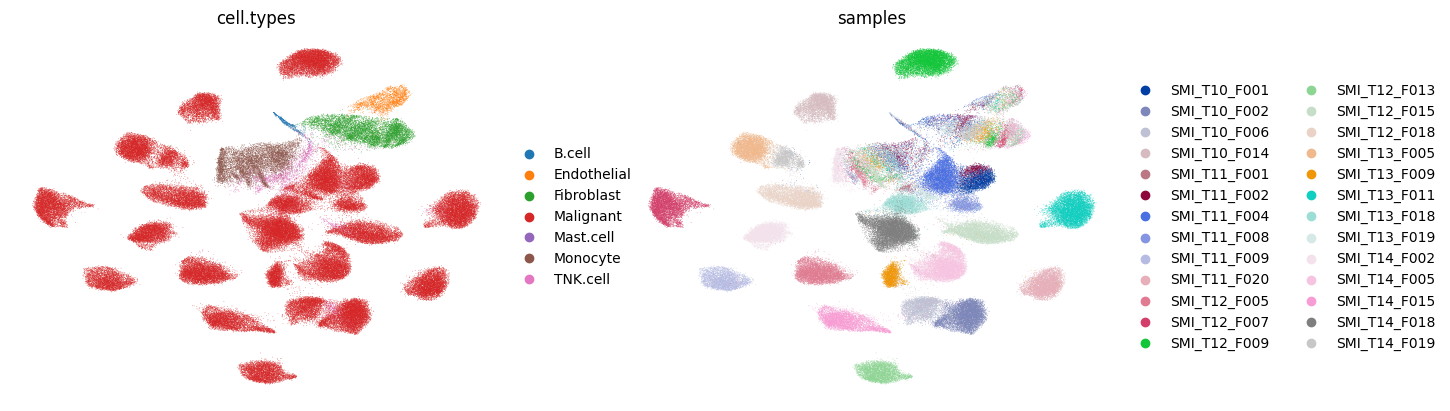

In [47]:
sc.pl.umap(adata, color=['cell.types', 'samples'], frameon=False)